In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image

from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

tf.config.run_functions_eagerly(True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Global variables
SAVE = False
SEED = 10

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

In [3]:
def create_images_list(path):
    data = []
    images = os.listdir(path)
    for i in tqdm(images, desc='images'):
        data.append(os.path.join(path, i))
        
    return data
    
data_normal = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Normal')
data_glioma = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor')
data_meningioma = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Tumor/meningioma_tumor')
data_pituitary = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor')

N_TYPES = 4

tumor_classes = {0 : 'normal',
                 1 : 'glioma',
                 2 : 'meningioma',
                 3 : 'pituitary'}

df = pd.concat([pd.DataFrame({"img": np.array(data_normal), "class": 0}),
                      pd.DataFrame({"img": np.array(data_glioma), "class":1}),
                      pd.DataFrame({"img": np.array(data_meningioma), "class":2}),
                      pd.DataFrame({"img": np.array(data_pituitary), "class":3}),
                     ], ignore_index = True)


df = shuffle(df).reset_index().drop(columns=['index'])
df.head()

images:   0%|          | 0/3066 [00:00<?, ?it/s]

images:   0%|          | 0/6307 [00:00<?, ?it/s]

images:   0%|          | 0/6391 [00:00<?, ?it/s]

images:   0%|          | 0/5908 [00:00<?, ?it/s]

,img,class
0,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,1
1,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,2
2,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,1
3,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,1
4,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,2


0 - Normal: 3066
1 - Glioma Tumor: 6307
2 - Meningioma Tumor: 6391
3 - Pituitary Tumor: 5908


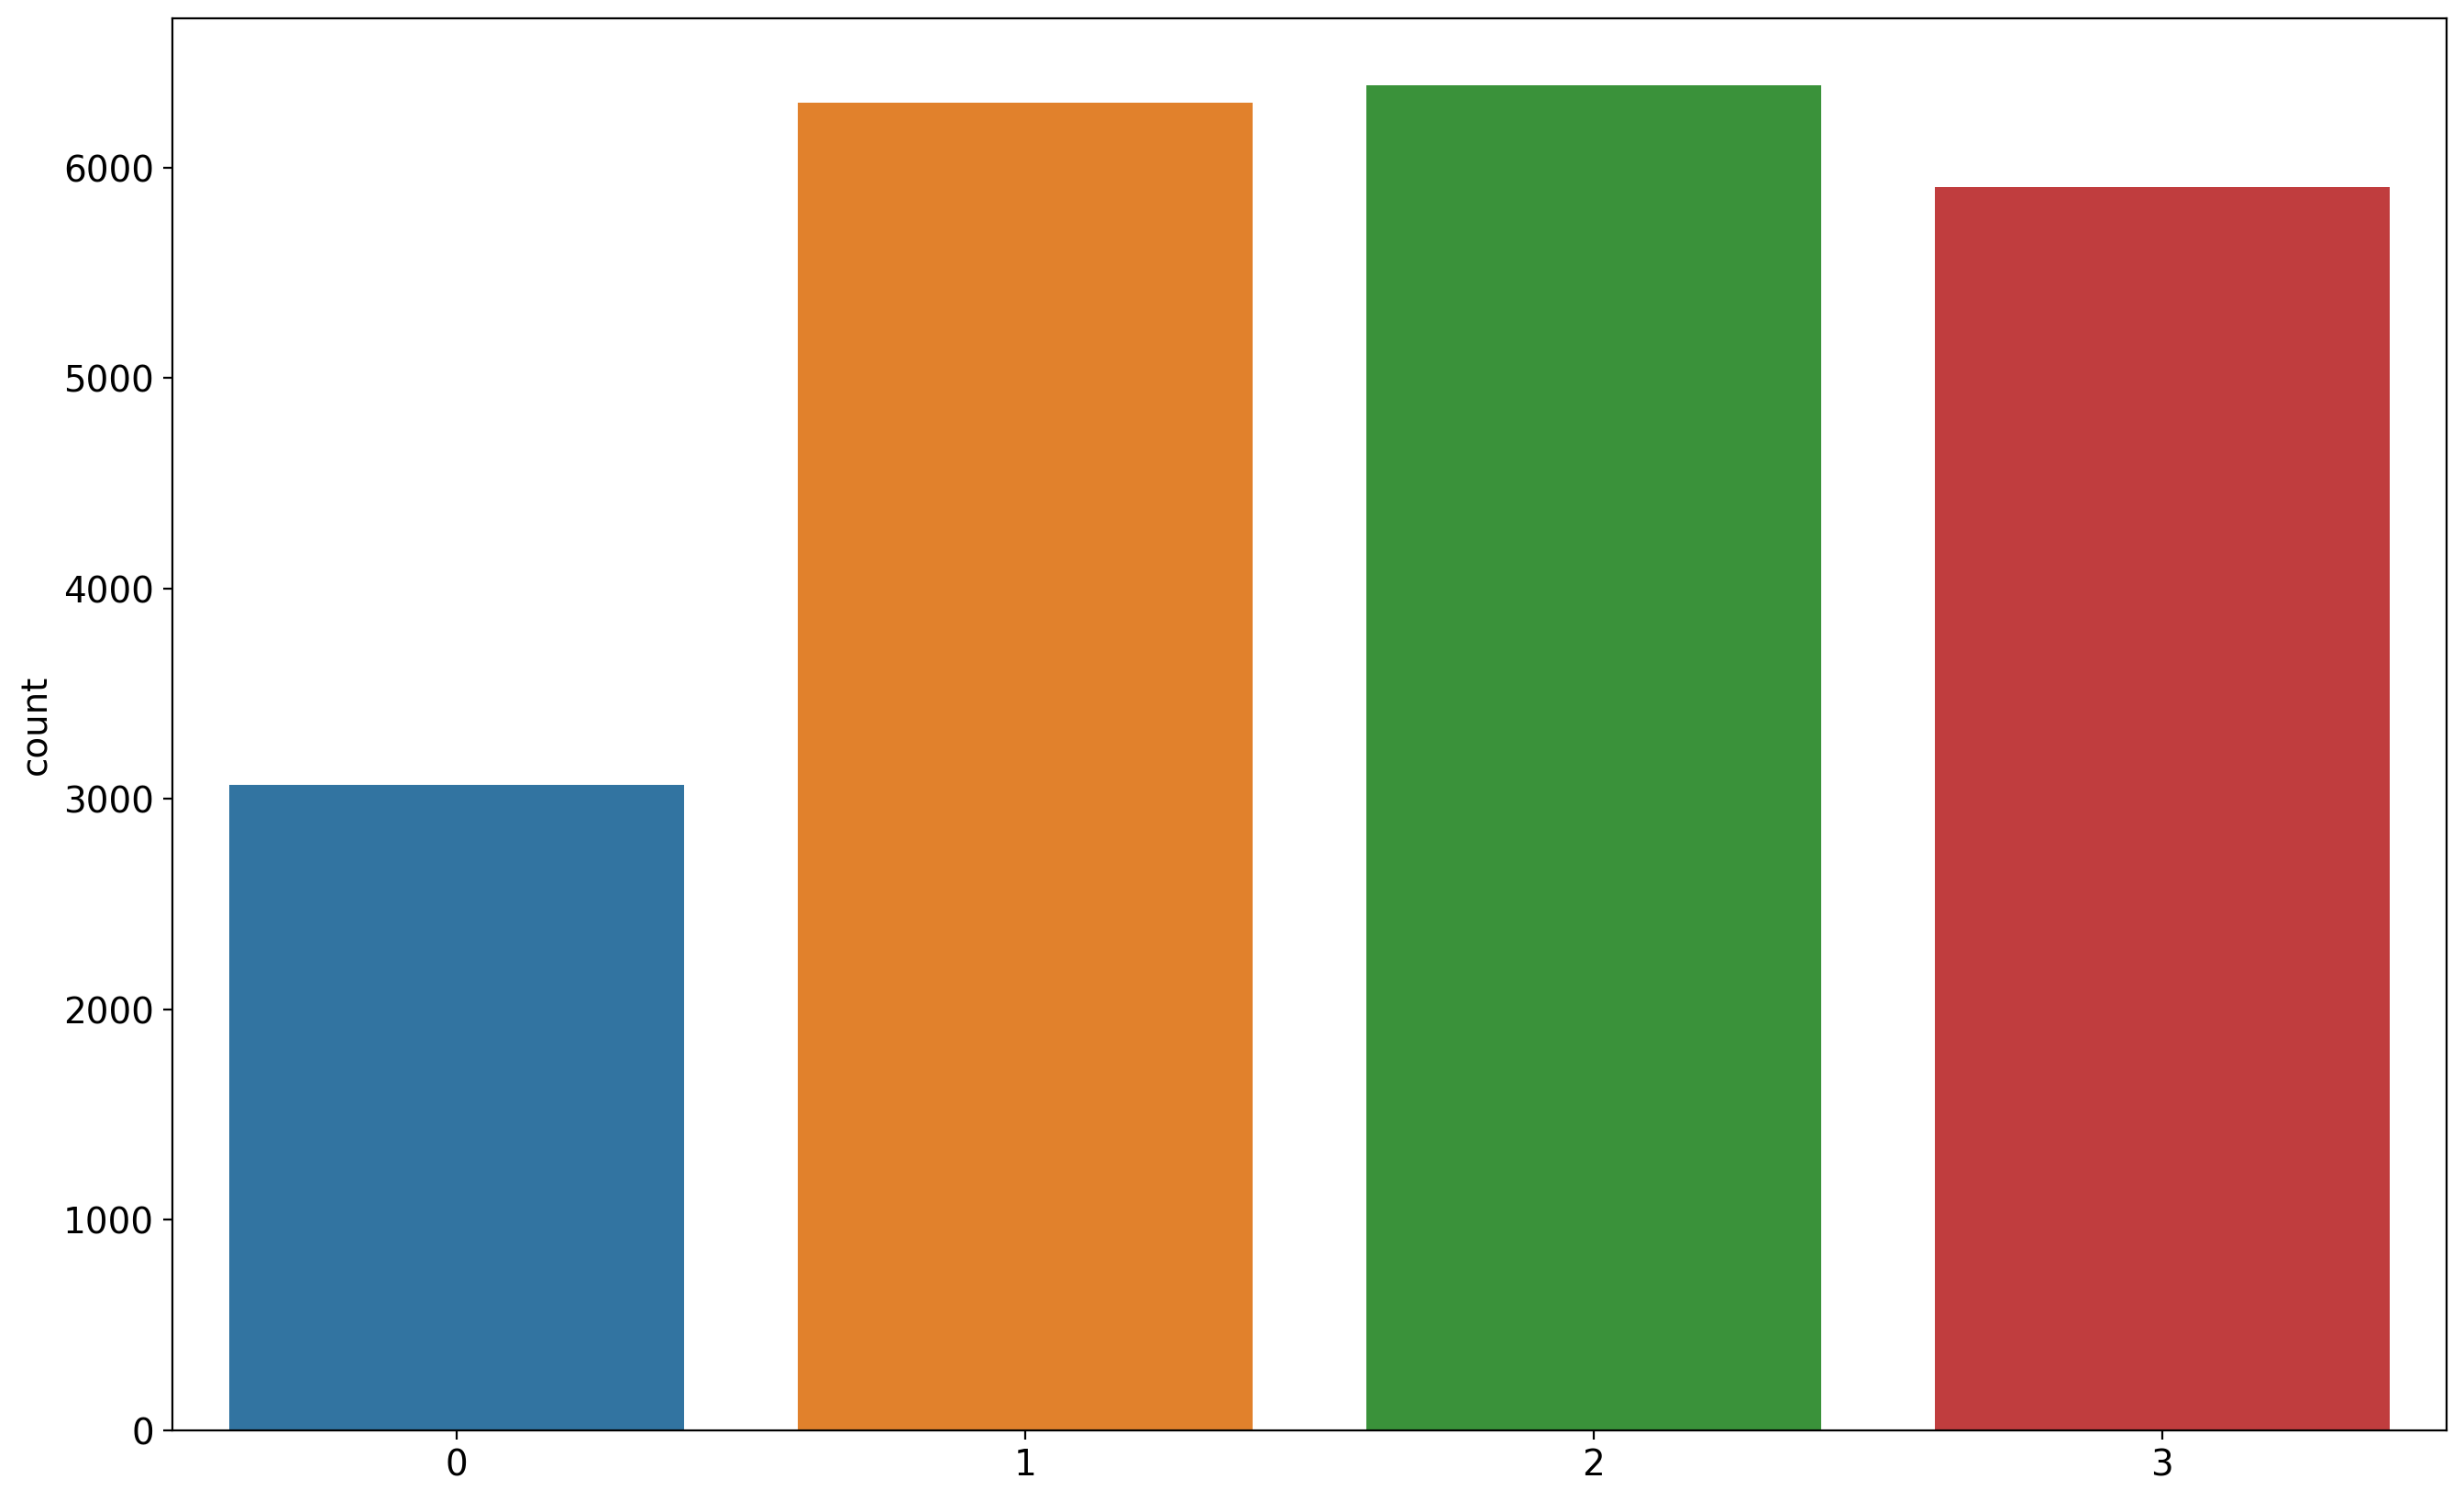

In [4]:
len_normal = range(0,len(data_normal))
len_glioma = range(0,len(data_glioma))
len_meningioma = range(0,len(data_meningioma))
len_pituitary = range(0,len(data_pituitary))

print("0 - Normal:",len(data_normal))
print("1 - Glioma Tumor:", len(data_glioma))
print("2 - Meningioma Tumor:",len(data_meningioma))
print("3 - Pituitary Tumor:",len(data_pituitary))

sns.countplot([len_normal, len_glioma, len_meningioma, len_pituitary])
plt.show()

In [5]:
X_train_, X_test, y_train_, y_test = train_test_split(df['img'], df['class'], test_size = 0.2, random_state=SEED)

X_train = X_train_[3500:]
X_val = X_train_[:3500]


y_train_ = tf.keras.utils.to_categorical(y_train_)

y_train = y_train_[3500:]
y_val = y_train_[:3500]
y_test = tf.keras.utils.to_categorical(y_test)


print("X_train shape -> ", X_train.shape)
print("X_val shape -> ", X_val.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (13837,)
X_val shape ->  (3500,)
X_test shape ->  (4335,)


x reshaped: (1, 150, 150, 3)


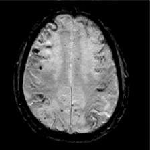

In [6]:
# getting image to test output
im = load_img(X_test[53], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [7]:
# Image shape: height, width, RBG
image_size = (150, 150)
image_shape = (image_size[0], image_size[1], 1)

# Training parameters
epochs = 20
batch_size = 150

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

Image shape: (150, 150, 1)
Epochs: 20
Batch size: 150


In [8]:
# Preprocessing function for dataset loader.
# read -> convert -> resize -> scaling

def img_preprocessing(image, label):

    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, size = (150,150))
    img = img/255.0
    
    return img, label

In [10]:
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train) )
train_dataset = (train_loader.map(img_preprocessing).batch(32).shuffle(X_train.shape[0]).prefetch(32))

validation_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val) )
validation_dataset = (train_loader.map(img_preprocessing).batch(32).shuffle(X_val.shape[0]).prefetch(32) )

test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test) )
test_dataset = (test_loader.map(img_preprocessing).batch(32).shuffle(X_test.shape[0]).prefetch(32))

In [11]:
# Define the model architecture
model = models.Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3))) #

# Convolutional layer 4
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Flatten())

# Full connect layers
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed=10))
model.add(Dense(N_TYPES, activation="softmax"))

model.summary()

optimizer = legacy.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

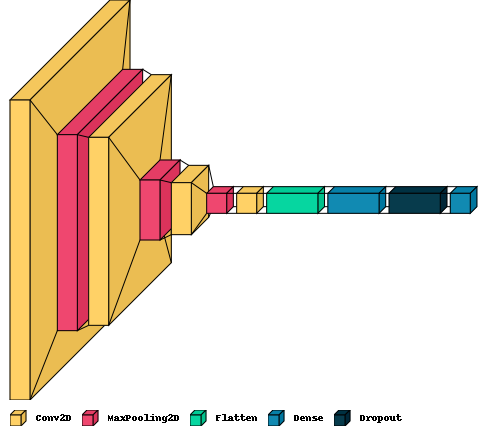

In [14]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)

In [15]:
# addition of callbacks
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=6, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)
model_cp = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy')

In [16]:
# Training the model
history = model.fit(train_dataset,epochs=epochs,batch_size=batch_size,
                    verbose=1,validation_data=validation_dataset,
                    callbacks=[model_es, model_rlr, model_cp])

Epoch 1/20
433/433 [==============================] - 64s 70ms/step - loss: 0.9221 - accuracy: 0.5928 - val_loss: 0.6365 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


433/433 [==============================] - 37s 68ms/step - loss: 0.5154 - accuracy: 0.7995 - val_loss: 0.3084 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 3/20
433/433 [==============================] - 38s 70ms/step - loss: 0.2985 - accuracy: 0.8889 - val_loss: 0.1719 - val_accuracy: 0.9353 - lr: 0.0010
Epoch 4/20
433/433 [==============================] - 38s 69ms/step - loss: 0.1882 - accuracy: 0.9314 - val_loss: 0.1071 - val_accuracy: 0.9657 - lr: 0.0010
Epoch 5/20
433/433 [==============================] - 38s 70ms/step - loss: 0.1373 - accuracy: 0.9499 - val_loss: 0.1092 - val_accuracy: 0.9596 - lr: 0.0010
Epoch 6/20
433/433 [==============================] - 37s 69ms/step - loss: 0.0830 - accuracy: 0.9704 - val_loss: 0.0428 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 7/20
433/433 [==============================] - 37s 69ms/step - loss: 0.0735 - accuracy: 0.9752 - val_loss: 0.0931 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 8/20
433/433 [==============================] - 38s 70ms/step -

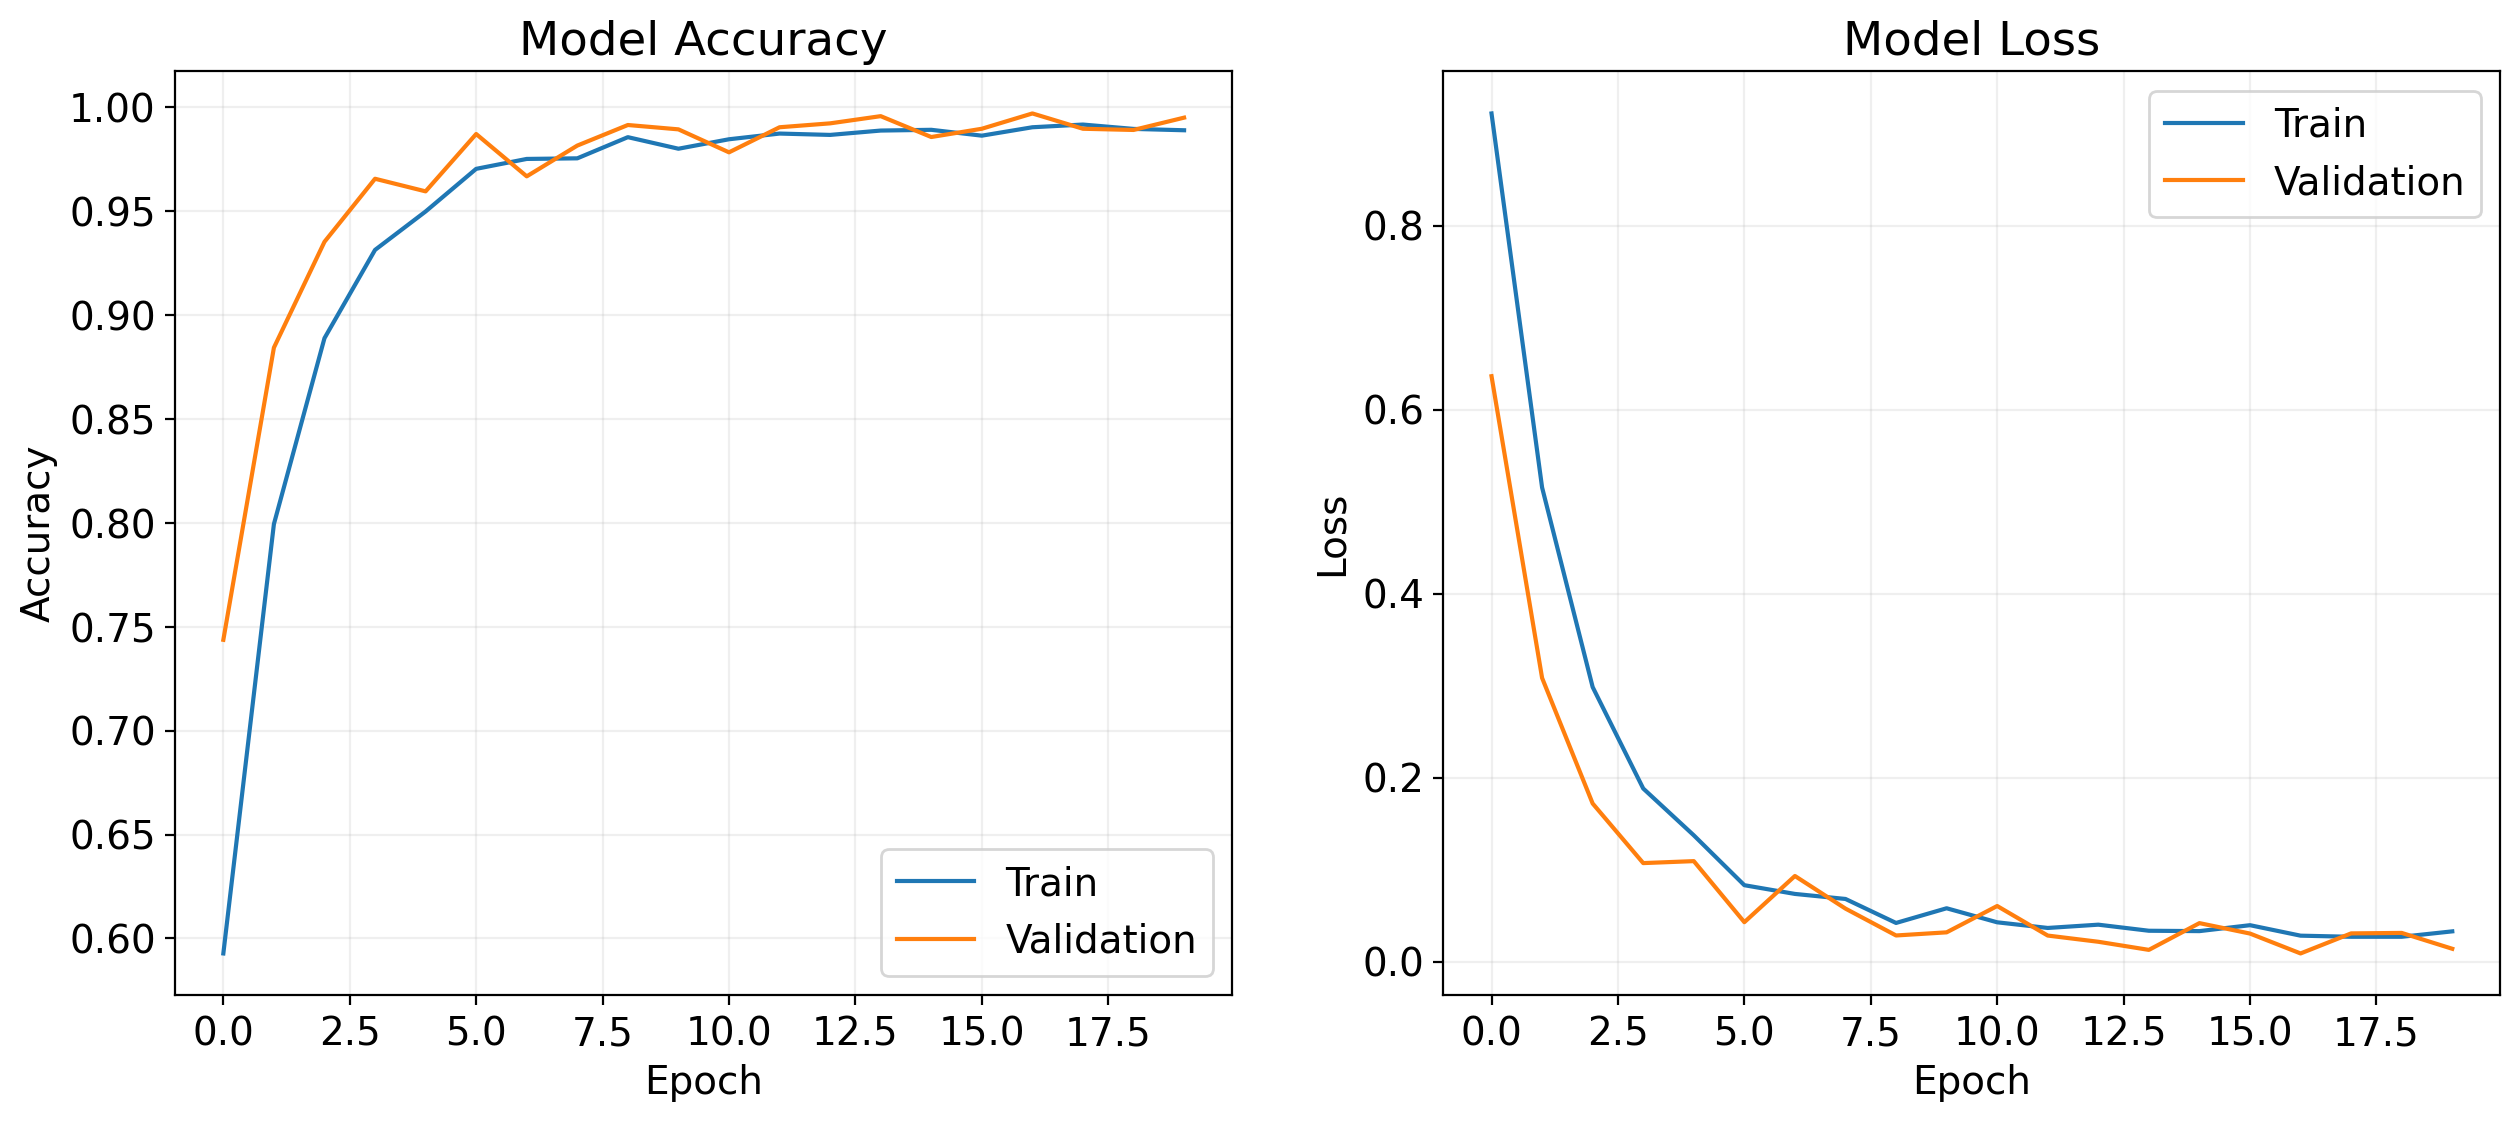

In [17]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [227]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/working/best_weights.h5')

In [147]:
train_score = model.evaluate(train_dataset, verbose= 1)
valid_score = model.evaluate(validation_dataset, verbose= 1)
test_score = model.evaluate(test_dataset, verbose= 1)

print('Train Accuracy: {0:.3f} %'.format(train_score[1]*100))
print('--' * 20)
print('Validation Accuracy: {0:.3f} %'.format(valid_score[1]*100))
print('--' * 20)
print('Test Accuracy: {0:.3f} %'.format(test_score[1]*100))

136/136 [==============================] - 5s 18ms/step - loss: 0.2065 - accuracy: 0.9559
Train Accuracy: 99.711 %
----------------------------------------
Validation Accuracy: 99.711 %
----------------------------------------
Test Accuracy: 95.594 %


In [228]:
test_score = model.evaluate(test_dataset)
print('Test Accuracy: {0:.3f} %'.format(test_score[1]*100))

136/136 [==============================] - 5s 20ms/step - loss: 0.2065 - accuracy: 0.9559
Test Accuracy: 95.594 %


In [237]:
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1) 

136/136 [==============================] - 4s 8ms/step


In [241]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Assuming test_dataset is a TensorFlow dataset
true_labels = []
predicted_labels = []

for batch in test_dataset:
    images, labels = batch

    # Predict classes for the batch
    predictions = model.predict(images, verbose=False)
    predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to class indices
    true_classes = np.argmax(labels, axis=1)

    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, target)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [251]:
cm

array([[ 620,   10,   11,    4],
       [  24, 1151,   54,    4],
       [   5,   48, 1229,   10],
       [   2,    6,   13, 1144]])

In [263]:
class_report = classification_report(true_labels, predicted_labels,target_names=['Normal','Glioma','Meningioma','Pituitary'])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.95      0.96      0.96       645
      Glioma       0.95      0.93      0.94      1233
  Meningioma       0.94      0.95      0.95      1292
   Pituitary       0.98      0.98      0.98      1165

    accuracy                           0.96      4335
   macro avg       0.96      0.96      0.96      4335
weighted avg       0.96      0.96      0.96      4335



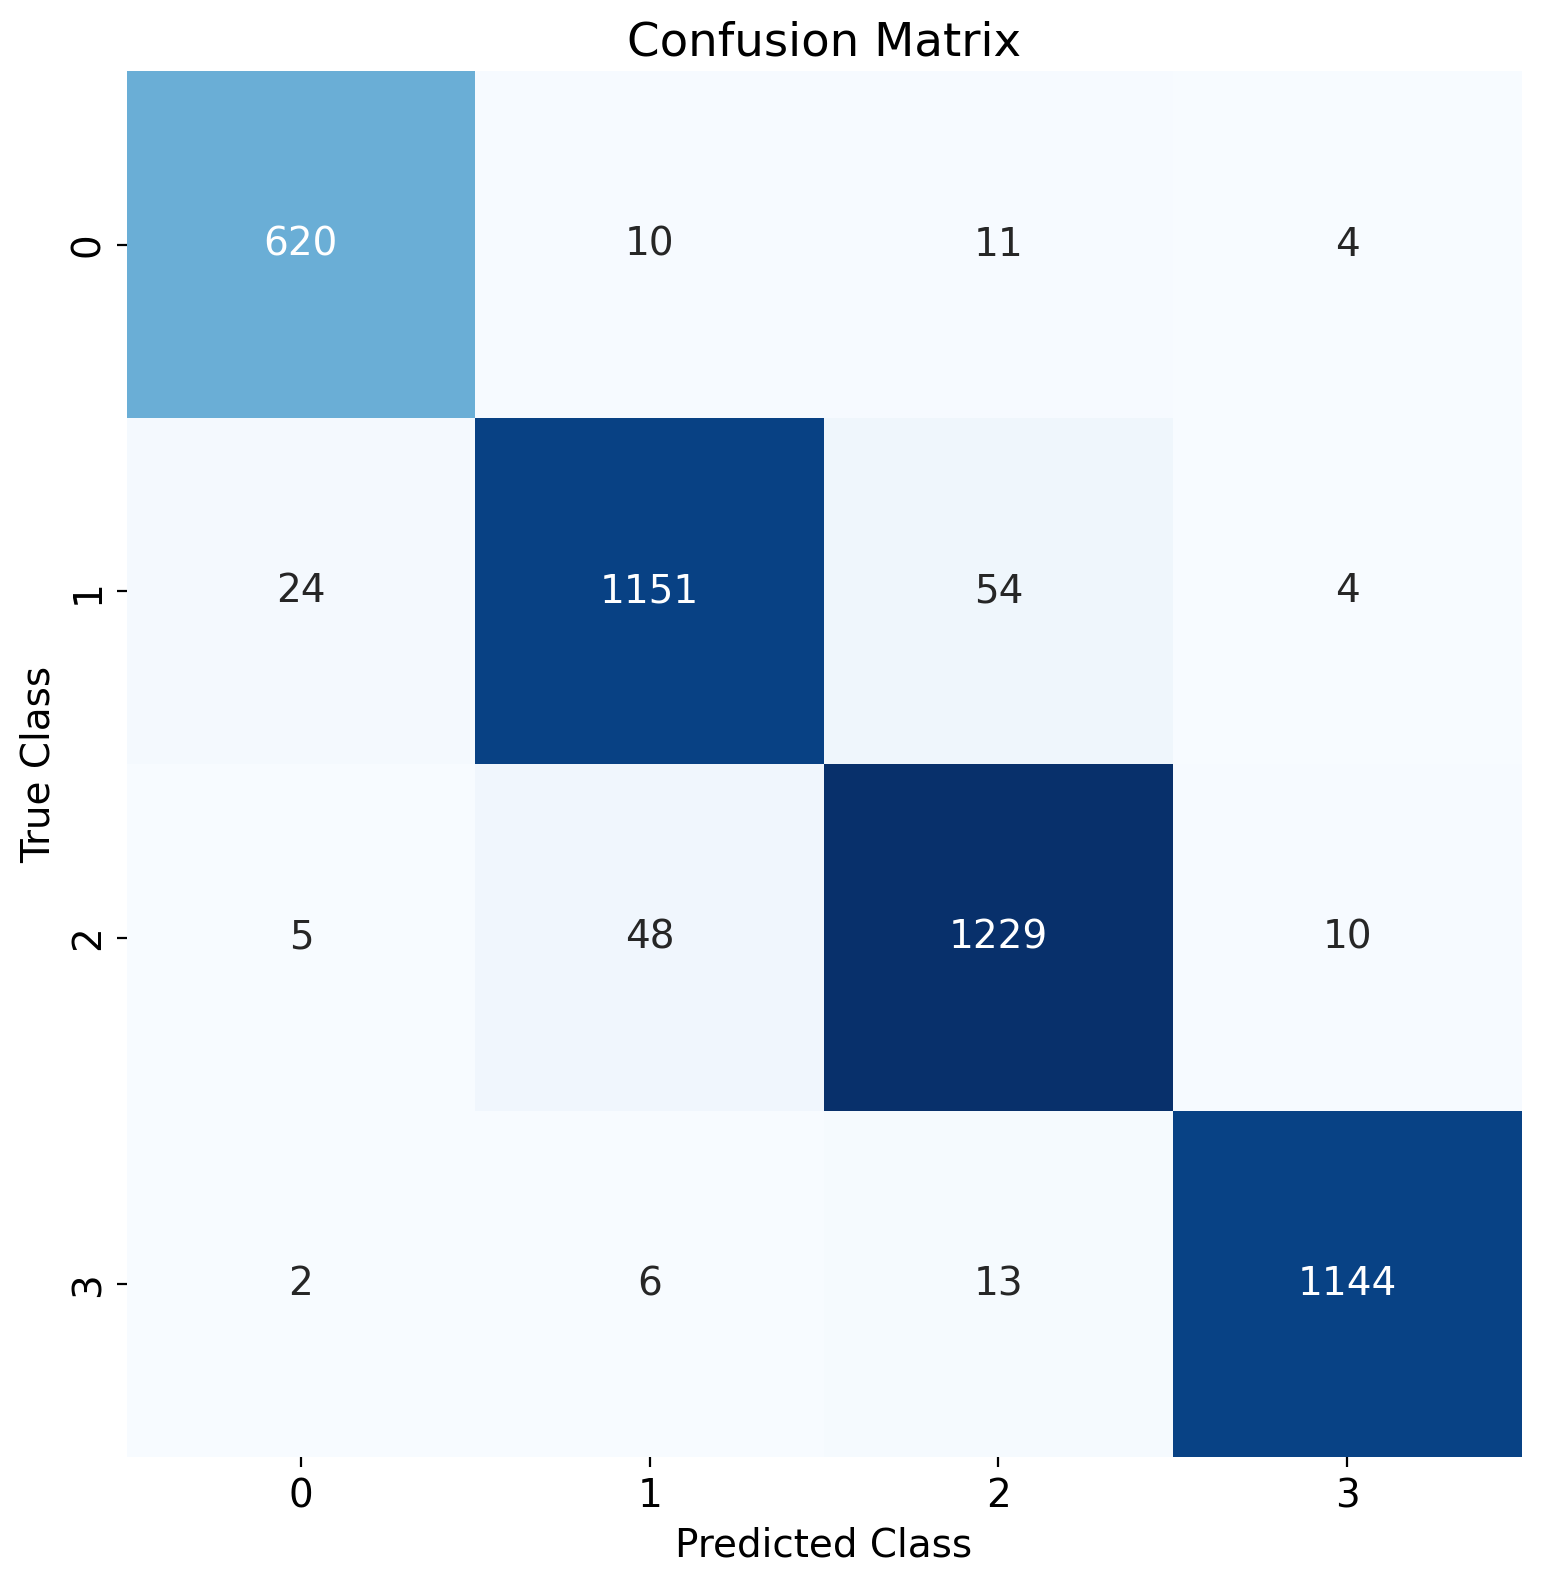

In [264]:
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()